In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.compose import ColumnTransformer
import joblib

In [3]:
import os
import pandas as pd

csv_path = '/kaggle/input/studentperformancefactors/StudentPerformanceFactors.csv'

if os.path.exists(csv_path):
    df = pd.read_csv(csv_path)
    print(f'Loaded {csv_path}')
else:
    raise FileNotFoundError(f'CSV not found at {csv_path}')



Loaded /kaggle/input/studentperformancefactors/StudentPerformanceFactors.csv


In [4]:
print('\nDataset shape:', df.shape)
print(df.head())


Dataset shape: (6607, 20)
   Hours_Studied  Attendance Parental_Involvement Access_to_Resources  \
0             23          84                  Low                High   
1             19          64                  Low              Medium   
2             24          98               Medium              Medium   
3             29          89                  Low              Medium   
4             19          92               Medium              Medium   

  Extracurricular_Activities  Sleep_Hours  Previous_Scores Motivation_Level  \
0                         No            7               73              Low   
1                         No            8               59              Low   
2                        Yes            7               91           Medium   
3                        Yes            8               98           Medium   
4                        Yes            6               65           Medium   

  Internet_Access  Tutoring_Sessions Family_Income Teacher_

In [5]:
df.columns = [c.strip().lower().replace(' ', '_').replace('-', '_') for c in df.columns]

In [6]:
print('\nColumn types and null counts:')
print(df.dtypes)
print('\nNull counts:\n', df.isnull().sum())


Column types and null counts:
hours_studied                  int64
attendance                     int64
parental_involvement          object
access_to_resources           object
extracurricular_activities    object
sleep_hours                    int64
previous_scores                int64
motivation_level              object
internet_access               object
tutoring_sessions              int64
family_income                 object
teacher_quality               object
school_type                   object
peer_influence                object
physical_activity              int64
learning_disabilities         object
parental_education_level      object
distance_from_home            object
gender                        object
exam_score                     int64
dtype: object

Null counts:
 hours_studied                  0
attendance                     0
parental_involvement           0
access_to_resources            0
extracurricular_activities     0
sleep_hours                    0
pr

In [7]:
num_cols = df.select_dtypes(include=['number']).columns.tolist()
cat_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()

for c in num_cols:
    if df[c].isnull().any():
        df[c].fillna(df[c].median(), inplace=True)

for c in cat_cols:
    if df[c].isnull().any():
        df[c].fillna(df[c].mode().iloc[0], inplace=True)


/tmp/ipykernel_36/2222647644.py:10: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[c].fillna(df[c].mode().iloc[0], inplace=True)


In [8]:
# Histogram/distribution of target (assume column named 'final_score' or similar)
possible_target_names = ['final_score', 'final_mark', 'score', 'marks', 'final_grade', 'final_exam_score']

for t in possible_target_names:
    if t in df.columns:
        target_col = t
        break
else:
    # fall back: if dataset has a column that looks numeric and plausible
    numeric_candidates = [c for c in df.columns if c in num_cols and c not in ['id', 'index']]
    # choose the most plausible by last numeric column
    target_col = numeric_candidates[-1]
    print(f"Couldn't find a standard target column; falling back to '{target_col}'")

print('\nTarget column chosen:', target_col)


Couldn't find a standard target column; falling back to 'exam_score'

Target column chosen: exam_score


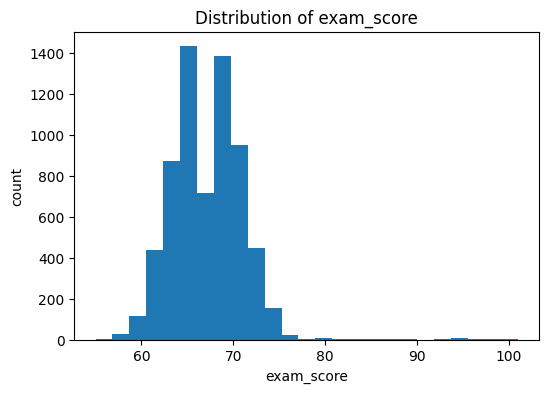

In [9]:
plt.figure(figsize=(6,4))
plt.hist(df[target_col].dropna(), bins=25)
plt.title('Distribution of ' + target_col)
plt.xlabel(target_col)
plt.ylabel('count')
plt.show()

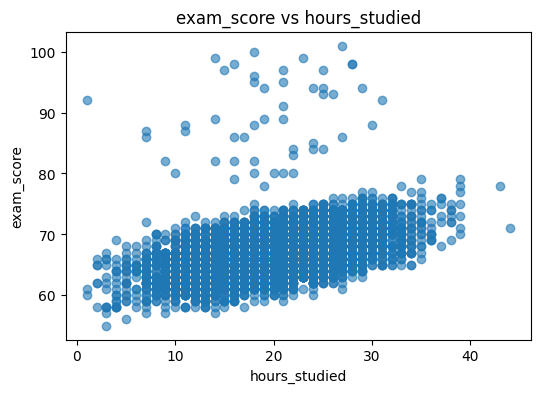

In [10]:
# Scatter: study_hours (if present) vs target
study_candidates = ['study_hours', 'weekly_study_hours', 'studytime', 'hours_studied', 'study_time']
study_col = None

for s in study_candidates:
    if s in df.columns:
        study_col = s
        break

if study_col:
    plt.figure(figsize=(6, 4))
    plt.scatter(df[study_col], df[target_col], alpha=0.6)
    plt.xlabel(study_col)
    plt.ylabel(target_col)
    plt.title(f'{target_col} vs {study_col}')
    plt.show()
else:
    print('No obvious study-hours column found — check column names:', df.columns.tolist())


In [11]:
if study_col:
    X = df[[study_col]].values
    y = df[target_col].values
else:
    # Use a few numeric features if no study_hours found.
    fallback_features = [c for c in num_cols if c != target_col][:3]
    X = df[fallback_features].values
    y = df[target_col].values
    study_col = None

In [12]:
# Identify numeric and categorical columns for modeling
numeric_features = [c for c in df.select_dtypes(include=['number']).columns.tolist() if c != target_col]
categorical_features = [c for c in df.select_dtypes(include=['object', 'category']).columns.tolist()]


numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])
preprocessor = ColumnTransformer(transformers=[
('num', numeric_transformer, numeric_features),
('cat', 'passthrough', categorical_features) # simple passthrough; you can add OneHotEncoder
])

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print('Train shape:', X_train.shape, 'Test shape:', X_test.shape)

Train shape: (5285, 1) Test shape: (1322, 1)


In [14]:
if study_col:
    lr = LinearRegression()
    lr.fit(X_train, y_train)
    y_pred = lr.predict(X_test)
    print('\nBaseline Linear Regression (study hours)')
    print('Coefficients:', lr.coef_, 'Intercept:', lr.intercept_)
    print('MAE:', mean_absolute_error(y_test, y_pred))
    print('MSE:', mean_squared_error(y_test, y_pred))
    print('RMSE:', mean_squared_error(y_test, y_pred, squared=False))
    print('R2:', r2_score(y_test, y_pred))


Baseline Linear Regression (study hours)
Coefficients: [0.28566874] Intercept: 61.51116746904424
MAE: 2.4475687452945643
MSE: 10.85592128879332
RMSE: 3.294832513010839
R2: 0.2319868674542106


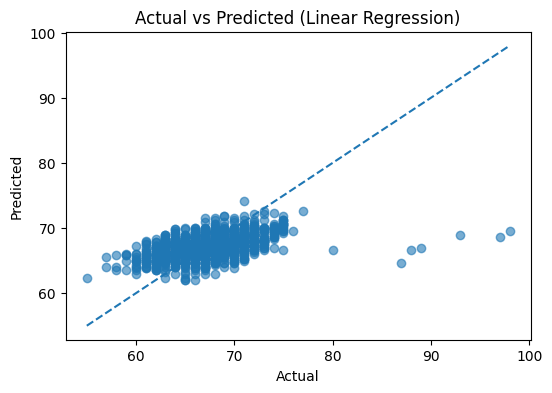

In [15]:
plt.figure(figsize=(6,4))
plt.scatter(y_test, y_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted (Linear Regression)')
plt.show()

In [16]:
if study_col:
    for deg in [2, 3]:
        pipe = Pipeline([
            ('poly', PolynomialFeatures(degree=deg, include_bias=False)),
            ('scaler', StandardScaler()),
            ('lr', LinearRegression())
        ])
        pipe.fit(X_train, y_train)
        y_pred = pipe.predict(X_test)
        print(f'\nPolynomial degree {deg} results:')
        print('MAE:', mean_absolute_error(y_test, y_pred))
        print('MSE:', mean_squared_error(y_test, y_pred))
        print('RMSE:', mean_squared_error(y_test, y_pred, squared=False))
        print('R2:', r2_score(y_test, y_pred))


Polynomial degree 2 results:
MAE: 2.4447795821288105
MSE: 10.84498813570501
RMSE: 3.2931729586684346
R2: 0.23276034442853466

Polynomial degree 3 results:
MAE: 2.44451162121857
MSE: 10.843834094915021
RMSE: 3.292997736852399
R2: 0.23284198821155666


In [17]:
X_full = df[numeric_features].copy()

In [18]:
if categorical_features:
    X_full = pd.concat([X_full, pd.get_dummies(df[categorical_features], drop_first=True)], axis=1)


y_full = df[target_col].values


Xf_train, Xf_test, yf_train, yf_test = train_test_split(X_full, y_full, test_size=0.2, random_state=42)


pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('lr', LinearRegression())
])

In [19]:
pipeline.fit(Xf_train, yf_train)
ypred_full = pipeline.predict(Xf_test)
print('\nMulti-feature Linear Regression results:')
print('MAE:', mean_absolute_error(yf_test, ypred_full))
print('MSE:', mean_squared_error(yf_test, ypred_full))
print('RMSE:', mean_squared_error(yf_test, ypred_full, squared=False))
print('R2:', r2_score(yf_test, ypred_full))


Multi-feature Linear Regression results:
MAE: 0.4523920089625971
MSE: 3.2560199870428943
RMSE: 1.804444509272284
R2: 0.7696495724907312


In [21]:
exp_name = 'sleep_hours'
if exp_name in df.columns:
    features_minus_sleep = [c for c in X_full.columns if c != exp_name]
    Xexp_train, Xexp_test = Xf_train[features_minus_sleep], Xf_test[features_minus_sleep]
    pipeline.fit(Xexp_train, yf_train)
    yexp = pipeline.predict(Xexp_test)
    print('\nExperiment: remove sleep_hours -> MAE:', mean_absolute_error(yf_test, yexp))
else:
    print('\nNo sleep_hours column to experiment with.')


Experiment: remove sleep_hours -> MAE: 0.4513744482135875


In [22]:
if study_col and 'attendance' in df.columns:
    df_inter = X_full.copy()
    df_inter['study_att_inter'] = df[study_col] * df['attendance']
    Xit_train, Xit_test, yit_train, yit_test = train_test_split(df_inter, y_full, test_size=0.2, random_state=42)
    pipeline.fit(Xit_train, yit_train)
    yit_pred = pipeline.predict(Xit_test)
    print('\nExperiment: add study*attendance interaction -> MAE:', mean_absolute_error(yit_test, yit_pred))


Experiment: add study*attendance interaction -> MAE: 0.45324976871515993


In [23]:
ridge_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('ridge', Ridge(alpha=1.0))
])

In [24]:
ridge_pipe.fit(Xf_train, yf_train)
yr = ridge_pipe.predict(Xf_test)
print('\nRidge Regression results:')
print('MAE:', mean_absolute_error(yf_test, yr))
print('MSE:', mean_squared_error(yf_test, yr))
print('R2:', r2_score(yf_test, yr))


Ridge Regression results:
MAE: 0.4523719769821078
MSE: 3.2559494406193963
R2: 0.7696545633688205


In [25]:
model_path = './models/student_score_model.pkl'
os.makedirs(os.path.dirname(model_path), exist_ok=True)
joblib.dump(pipeline, model_path)
print('\nSaved model to', model_path)


Saved model to ./models/student_score_model.pkl
